[ 46  10 204  84 184 195 171 208  93  48 121 155   9   7   6 122  86 189
  38 152 188  92 198  97  76 158 211 199   5  55  67  96 113 133 187  71
 149  70  47  61 127 135 162  95 160 130 103 205  58  81 144 161   2 129
 126 101  69  64 111 221 194  12 168 128  53 148  42  32  65 141 106  89
 124 146  16  50 147   8  40 104  90 119 183 203 108 190 213  31 140 105
  79  62 157 185 217 167 200 210 137 176  49 220  63  82 180 192 219   0
 218 115 142  19 209 107  74  36  41 186 216 173  33 110 182  35 165  20
 172 201 164 150  39  52 179 116 181 178 131  17  13 191 145 222  78 224
 223 215  11  15 151 177  87  88 132  26  29 174  60  85  14 139  98  77
  30 197 109 102  22  23 214  27  72 207 114  57  75  56  73 154  25  51
  94  54  45 163  80  28  43  37 136  83  66  24 120   4  68 175  99 138
 206   1 169 112 100  91 166  21 212 123 170 196 193 143  59 159 118  34
 117   3 156 134 202 125  18  44 153]
839.1048845448784 904.9703037081866 65.86541916330827
12.931761733972 22.7522516215920

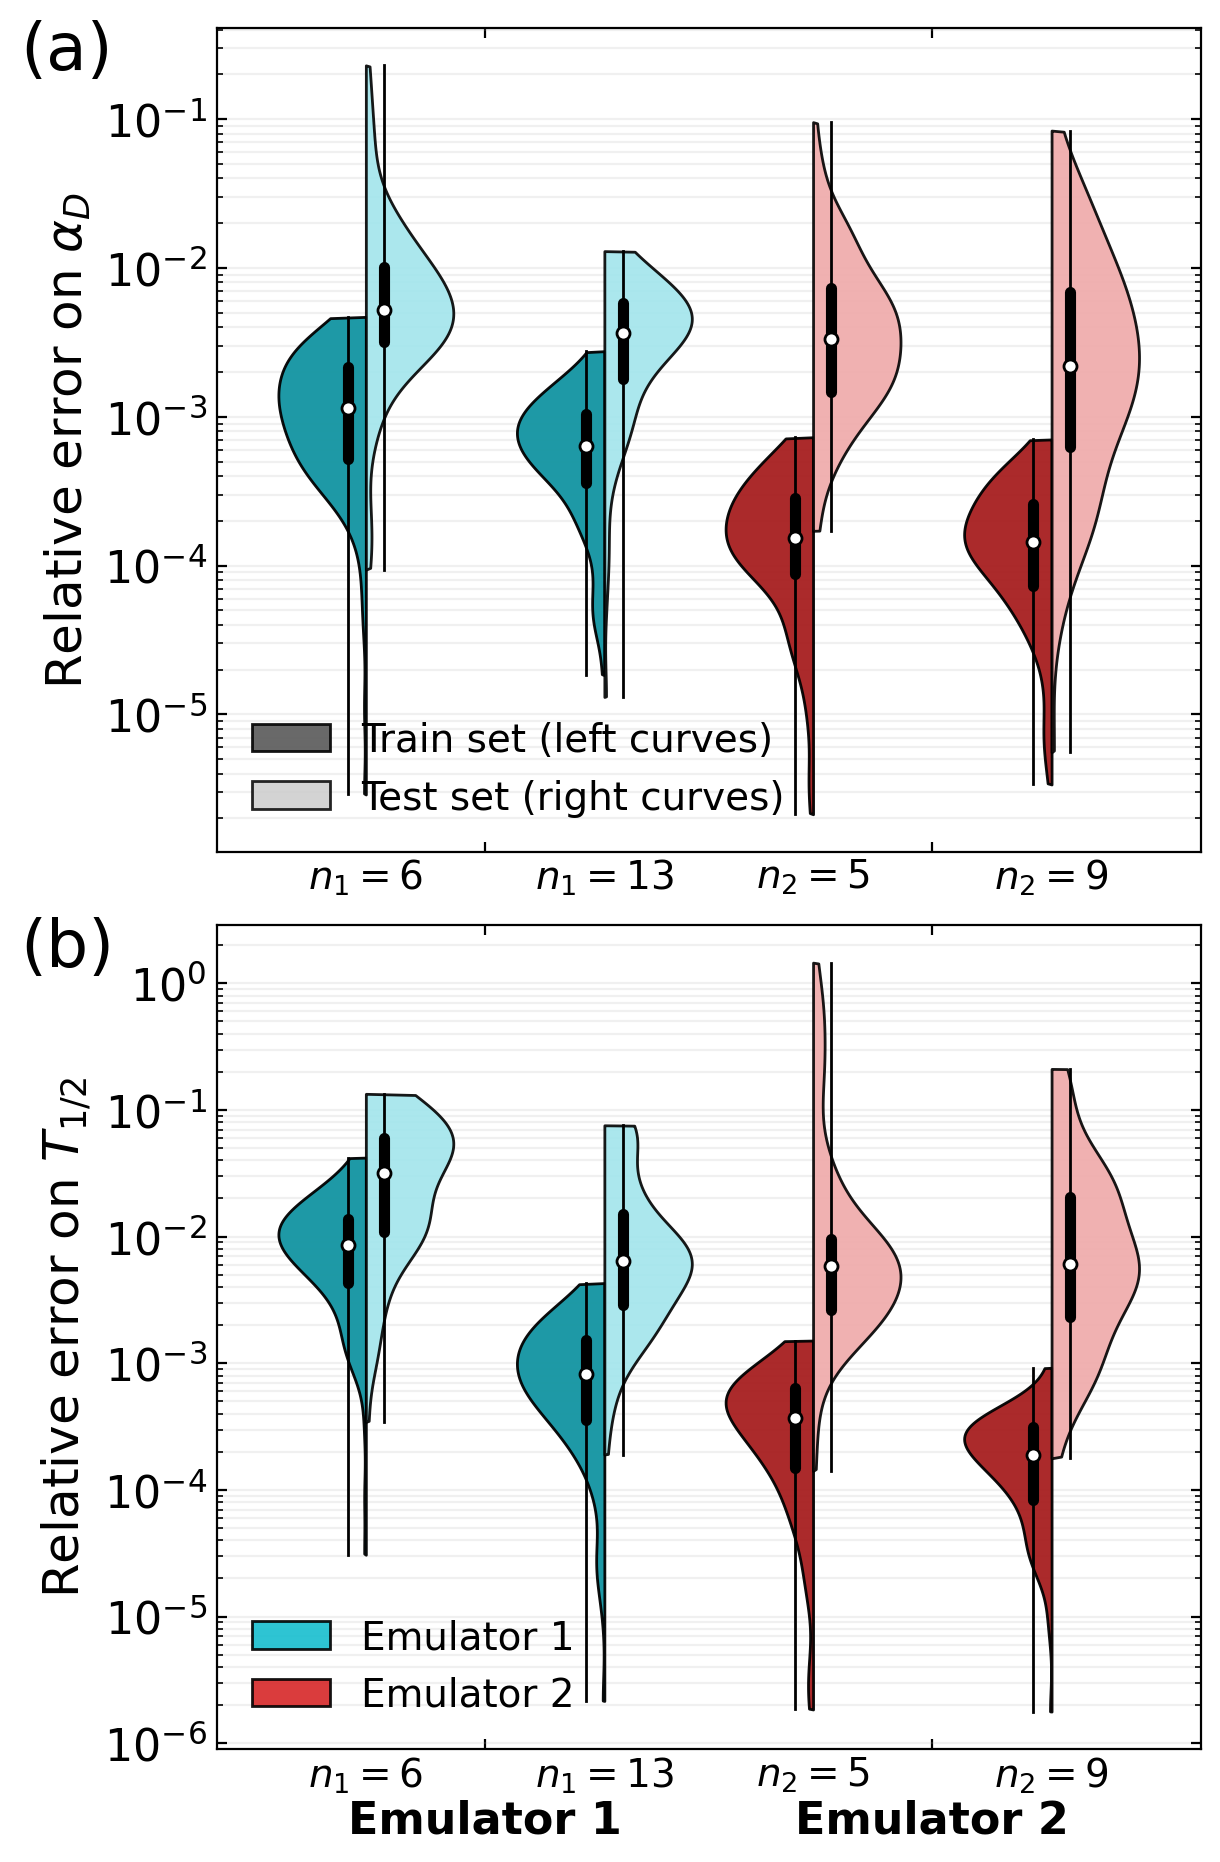


Saved SplitViolins_4violins.pdf


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import gaussian_kde
import re, os, sys
from pathlib import Path
from matplotlib.colors import to_rgb, to_hex
from matplotlib.patches import Patch

# ---------------------------------------------------------------------
# Project imports (same as CAT plot)
# ---------------------------------------------------------------------
sys.path.insert(0, str(Path("..").resolve()))
from Beta_decay import helper as beta_helper
from dipoles_exp_param import helper as dipole_helper

# --- emulator brand colors ---
EM1_COLOR = "#17becf"   # Cyan (Emulator 1)
EM2_COLOR = "#d62728"   # Strong red (Emulator 2)

# ---------------------------------------------------------------------
# Global style
# ---------------------------------------------------------------------
plt.rcParams.update({
    "xtick.direction": "in", "ytick.direction": "in",
    "xtick.top": True, "ytick.right": True,
    "xtick.minor.visible": True, "ytick.minor.visible": True,
    "xtick.labelsize": 16, "ytick.labelsize": 14,
    "axes.titlesize": 14, "axes.labelsize": 16,
})

# ---------------------------------------------------------------------
# Helpers (same logic as CAT plot)
# ---------------------------------------------------------------------
def load_train_set(path_txt):
    with open(path_txt, "r") as f:
        return [tuple(map(str, line.strip().split(","))) for line in f]

def centroid_like_point(train_set):
    arr = np.array(train_set, float)
    centroid = arr.mean(axis=0)
    idx = np.argmin(np.linalg.norm(arr - centroid, axis=1))
    return train_set[idx]

def bbox_midpoint_point(train_set):
    Amin = min(float(a) for a, b in train_set)
    Amax = max(float(a) for a, b in train_set)
    Bmin = min(float(b) for a, b in train_set)
    Bmax = max(float(b) for a, b in train_set)
    cx, cy = (Amin + Amax) / 2.0, (Bmin + Bmax) / 2.0
    return min(train_set, key=lambda t: (float(t[0]) - cx)**2 + (float(t[1]) - cy)**2)

def split_train_test(combined, train_set):
    mask_train = np.array([pt in train_set for pt in combined], dtype=bool)
    idx_train = np.nonzero(mask_train)[0]
    idx_test  = np.nonzero(~mask_train)[0]
    return idx_train, idx_test

# ---------------------------------------------------------------------
# Dipole (α_D)  -- update n's here and in desired_ns_em1 below
# ---------------------------------------------------------------------
def compute_dipole_data():
    train_set = load_train_set("../dipoles_exp_param/train_set.txt")
    central_point = bbox_midpoint_point(train_set)

    strength_dir = '../dipoles_data_all/total_strength/'
    alphaD_dir   = '../dipoles_data_all/total_alphaD/'
    pattern = re.compile(r'^strength_([0-9.]+)_([0-9.]+)\.out$')

    combined = []
    for fname in os.listdir(strength_dir):
        m = pattern.match(fname)
        if not m:
            continue
        beta, alpha = m.group(1), m.group(2)
        if os.path.exists(os.path.join(alphaD_dir, f'alphaD_{beta}_{alpha}.out')):
            combined.append((alpha, beta))

    idx_train, idx_test = split_train_test(combined, train_set)

    # Emulator 1
    retain = 0.6
    em1 = []
    for n in [6, 13]:
        params = np.loadtxt(f'../dipoles_exp_param/params_best_n{n}_retain{retain}.txt').astype(np.float32)
        alphaD, alphaD_test, times = dipole_helper.plot_alphaD(combined, params, n, central_point, retain)
        rel = np.abs(np.array(alphaD_test) - np.array(alphaD)) / np.array(alphaD_test)
        em1.append(dict(n=n, times=np.asarray(times), rel=np.asarray(rel)))

    # Emulator 2
    em2 = []
    for n in [5, 9]:
        params = np.loadtxt(f'../dipoles_exp_param/params_{n}_only_alphaD.txt').astype(np.float32)
        alphaD, alphaD_test, times = dipole_helper.plot_alphaD_simple(combined, params, n, central_point)
        rel = np.abs(np.array(alphaD_test) - np.array(alphaD)) / np.array(alphaD_test)
        em2.append(dict(n=n, times=np.asarray(times), rel=np.asarray(rel)))

    return dict(combined=combined, idx_train=idx_train, idx_test=idx_test, em1=em1, em2=em2)

# ---------------------------------------------------------------------
# Beta decay (T1/2)
# ---------------------------------------------------------------------
def compute_beta_data():
    A, Z, g_A, nucnam = 80, 28, 1.2, "Ni_80"
    coeffs = Polynomial(beta_helper.fit_phase_space(0, Z, A, 15)).coef

    train_set = load_train_set("../Beta_decay/train_set.txt")
    central_point = centroid_like_point(train_set)

    strength_dir = f'../beta_decay_data_{nucnam}/'
    pattern = re.compile(rf'^lorm_{nucnam}_([0-9.]+)_([0-9.]+)\.out$')

    combined = []
    for fname in os.listdir(strength_dir):
        m = pattern.match(fname)
        if m:
            beta_val, alpha_val = m.group(1), m.group(2)
            combined.append((alpha_val, beta_val))

    idx_train, idx_test = split_train_test(combined, train_set)

    # Emulator 1
    em1 = []
    for n in [6, 13]:
        params = np.loadtxt(f'../Beta_decay/params_best_n{n}_retain0.9.txt')
        HLs, HLs_test, times = beta_helper.plot_half_lives(combined, params, n, coeffs, g_A, central_point, nucnam, 0.9)
        rel = np.abs(np.array(HLs_test) - np.array(HLs)) / np.array(HLs_test)
        em1.append(dict(n=n, times=np.asarray(times), rel=np.asarray(rel)))

    # Emulator 2
    em2 = []
    for n in [5, 9]:
        params = np.loadtxt(f'../Beta_decay/params_{n}_only_HL.txt')
        HLs, HLs_test, times = beta_helper.plot_half_lives_only_HL(combined, params, n, coeffs, g_A, central_point, nucnam)
        rel = np.abs(np.array(HLs_test) - np.array(HLs)) / np.array(HLs_test)
        em2.append(dict(n=n, times=np.asarray(times), rel=np.asarray(rel)))

    return dict(combined=combined, idx_train=idx_train, idx_test=idx_test, em1=em1, em2=em2)

# ---------------------------------------------------------------------
# Color helpers
# ---------------------------------------------------------------------
def _lighten(hexcolor, amount=0.45):
    r, g, b = to_rgb(hexcolor)
    r = 1 - (1 - r) * (1 - amount)
    g = 1 - (1 - g) * (1 - amount)
    b = 1 - (1 - b) * (1 - amount)
    return to_hex((r, g, b))

def _darken(hexcolor, amount=0.25):
    r, g, b = to_rgb(hexcolor)
    return to_hex((r*(1-amount), g*(1-amount), b*(1-amount)))

# ---------------------------------------------------------------------
# Split violin with COMMON support and exact min–max caps
# ---------------------------------------------------------------------
def split_violin(ax, left_vals, right_vals, xcenter, *,
                 color="#0072B2", width=0.55, kde_pts=400, logy=True,
                 pad_dex=0.25, eps=1e-16):
    """As before, but draws halves on a common grid and clips exactly to min–max."""
    def clean(a):
        a = np.asarray(a, float)
        a = a[np.isfinite(a)]
        if logy:
            a = a[a > eps]
            a = np.clip(a, eps, None)
        return a

    def kde_on_grid(vals, vgrid):
        if vals.size == 0:
            return np.zeros_like(vgrid)
        v = np.log10(vals)
        if np.allclose(v.ptp(), 0.0, atol=1e-9):
            mu = float(v.mean()); s = 0.01
            dens = np.exp(-0.5 * ((vgrid - mu) / s) ** 2)
        else:
            try:
                kde = gaussian_kde(v, bw_method="scott")
                dens = kde(vgrid)
            except Exception:
                mu = float(np.median(v)); s = max(0.05, 0.34 * v.ptp())
                dens = np.exp(-0.5 * ((vgrid - mu) / s) ** 2)
        dens = np.clip(np.nan_to_num(dens, nan=0.0, posinf=0.0, neginf=0.0), 0.0, None)
        if dens.max() > 0:
            dens /= dens.max()
        return dens

    def cap_to_range(y, w, lo, hi, tiny=1e-15):
        mask = (y >= lo - tiny) & (y <= hi + tiny)
        y_in, w_in = y[mask], w[mask]
        if y_in.size == 0:
            y_in = np.array([lo, hi]); w_in = np.array([0.0, 0.0]); return y_in, w_in
        if y_in[0] > lo + tiny: y_in  = np.insert(y_in, 0, lo); w_in  = np.insert(w_in, 0, 0.0)
        else:                   y_in[0] = lo; w_in[0] = 0.0
        if y_in[-1] < hi - tiny: y_in = np.append(y_in, hi); w_in = np.append(w_in, 0.0)
        else:                    y_in[-1] = hi; w_in[-1] = 0.0
        return y_in, w_in

    def _light(hexcolor, amount=0.45):
        r, g, b = to_rgb(hexcolor)
        r = 1 - (1 - r) * (1 - amount)
        g = 1 - (1 - g) * (1 - amount)
        b = 1 - (1 - b) * (1 - amount)
        return to_hex((r, g, b))

    def _dark(hexcolor, amount=0.25):
        r, g, b = to_rgb(hexcolor)
        return to_hex((r*(1-amount), g*(1-amount), b*(1-amount)))

    L = clean(left_vals)
    R = clean(right_vals)
    if L.size + R.size == 0:
        return

    all_log = np.log10(np.concatenate([L, R])) if (L.size and R.size) else np.log10(L if L.size else R)
    vmin, vmax = float(all_log.min()), float(all_log.max())
    vgrid = np.linspace(vmin - pad_dex, vmax + pad_dex, kde_pts)
    ygrid = 10.0**vgrid if logy else vgrid

    dL = kde_on_grid(L, vgrid); dR = kde_on_grid(R, vgrid)
    wL = (width * 0.48) * dL;   wR = (width * 0.48) * dR

    if L.size: yL, wL = cap_to_range(ygrid, wL, float(L.min()), float(L.max()))
    else:      yL, wL = np.array([]), np.array([])
    if R.size: yR, wR = cap_to_range(ygrid, wR, float(R.min()), float(R.max()))
    else:      yR, wR = np.array([]), np.array([])

    left_col  = _dark(color, 0.22)
    right_col = _light(color, 0.60)
    if yL.size:
        ax.fill_betweenx(yL, xcenter, xcenter - wL, facecolor=left_col,
                         edgecolor="black", linewidth=1.0, alpha=0.95, zorder=2)
    if yR.size:
        ax.fill_betweenx(yR, xcenter, xcenter + wR, facecolor=right_col,
                         edgecolor="black", linewidth=1.0, alpha=0.90, zorder=2)

    def iqr_stats(vals):
        q1, med, q3 = np.percentile(vals, [25, 50, 75]); return q1, med, q3
    dx = width * 0.10
    for vals, xc in [(L, xcenter - dx), (R, xcenter + dx)]:
        if vals.size == 0: continue
        q1, med, q3 = iqr_stats(vals); lo, hi = float(vals.min()), float(vals.max())
        ax.plot([xc, xc], [lo, hi], color="k", lw=1.0, zorder=3)
        ax.plot([xc, xc], [q1, q3], color="k", lw=4.0, solid_capstyle="round", zorder=4)
        ax.scatter([xc], [med], s=22, facecolor="white", edgecolor="black", zorder=5)

# ---------------------------------------------------------------------
# Stats printing utilities
# ---------------------------------------------------------------------
def _collect_per_n(em_list, idx_train, idx_test):
    out = []
    for d in em_list:
        rel = np.asarray(d["rel"])
        out.append((d["n"], rel[idx_train], rel[idx_test]))
    return out

def _order_by_ns(records, desired_ns):
    rmap = {n: (tr, te) for (n, tr, te) in records}
    return [(n, *rmap[n]) for n in desired_ns if n in rmap]

def _basic_stats(arr):
    arr = np.asarray(arr, float)
    mean = np.mean(arr)
    std  = np.std(arr, ddof=1) if arr.size > 1 else 0.0
    q1, med, q3 = np.percentile(arr, [25, 50, 75])
    iqr = q3 - q1
    lo, hi = float(np.min(arr)), float(np.max(arr))
    return dict(mean=mean, std=std, q1=q1, median=med, q3=q3, iqr=iqr, lo=lo, hi=hi)

def _fmt_pct(x):
    return f"{100.0*x:.3g}%"

def print_panel_stats(name, data, desired_ns_em1, desired_ns_em2):
    em1 = _order_by_ns(_collect_per_n(data["em1"], data["idx_train"], data["idx_test"]), desired_ns_em1)
    em2 = _order_by_ns(_collect_per_n(data["em2"], data["idx_train"], data["idx_test"]), desired_ns_em2)

    def _print_group(tag, recs):
        print(f"\n{tag}:")
        print(" n   |  TRAIN median  IQR   [min,max]   ||   TEST median   IQR   [min,max]")
        print("-----+-----------------------------------++-----------------------------------")
        for n, tr, te in recs:
            st_tr = _basic_stats(tr); st_te = _basic_stats(te)
            line = (
                f"{n:>3} | "
                f"{_fmt_pct(st_tr['median']):>12} {_fmt_pct(st_tr['iqr']):>6} "
                f"[{_fmt_pct(st_tr['lo'])},{_fmt_pct(st_tr['hi'])}]   ||   "
                f"{_fmt_pct(st_te['median']):>12} {_fmt_pct(st_te['iqr']):>6} "
                f"[{_fmt_pct(st_te['lo'])},{_fmt_pct(st_te['hi'])}]"
            )
            print(line)

    print(f"\n=== {name} ===")
    _print_group("Emulator 1", em1)
    _print_group("Emulator 2", em2)

# ---------------------------------------------------------------------
# Panel drawing (4 violins per subplot)
# ---------------------------------------------------------------------
def _draw_panel(ax, data, title, ylabel, desired_ns_em1, desired_ns_em2, logy=True):
    em1_recs = _collect_per_n(data["em1"], data["idx_train"], data["idx_test"])
    em2_recs = _collect_per_n(data["em2"], data["idx_train"], data["idx_test"])
    em1 = _order_by_ns(em1_recs, desired_ns_em1)
    em2 = _order_by_ns(em2_recs, desired_ns_em2)

    VIOLIN_WIDTH = 0.55
    WITHIN_GAP   = 0.72
    GROUP_GAP    = 1.35

    x0 = 0.00
    xpos = [x0, x0 + WITHIN_GAP, x0 + GROUP_GAP, x0 + GROUP_GAP + WITHIN_GAP]
    major_centers = [(xpos[0] + xpos[1]) / 2.0, (xpos[2] + xpos[3]) / 2.0]

    if len(em1) >= 1:
        _, tr, te = em1[0]
        split_violin(ax, tr, te, xpos[0], color=EM1_COLOR, width=VIOLIN_WIDTH, logy=logy)
    if len(em1) >= 2:
        _, tr, te = em1[1]
        split_violin(ax, tr, te, xpos[1], color=EM1_COLOR, width=VIOLIN_WIDTH, logy=logy)
    if len(em2) >= 1:
        _, tr, te = em2[0]
        split_violin(ax, tr, te, xpos[2], color=EM2_COLOR, width=VIOLIN_WIDTH, logy=logy)
    if len(em2) >= 2:
        _, tr, te = em2[1]
        split_violin(ax, tr, te, xpos[3], color=EM2_COLOR, width=VIOLIN_WIDTH, logy=logy)

    ax.set_xlim(xpos[0] - 0.45, xpos[3] + 0.45)
    if logy: ax.set_yscale("log")
    ax.grid(alpha=0.18, axis="y", which="both")
    ax.set_ylabel(ylabel); ax.set_title(title, loc="left")

    ax.set_xticks(major_centers, ["Emulator 1", "Emulator 2"])

    minor_labels = [rf"$n_1={desired_ns_em1[0]}$", rf"$n_1={desired_ns_em1[1]}$",
                    rf"$n_2={desired_ns_em2[0]}$", rf"$n_2={desired_ns_em2[1]}$"]
    ax.set_xticks(xpos, minor=True)
    ax.set_xticklabels(minor_labels, minor=True, fontsize=14)
    ax.tick_params(axis="x", which="minor", pad=2, length=0)

    mid = 0.5 * (xpos[1] + xpos[2])
    ax.plot([mid, mid], [0, -0.035], transform=ax.get_xaxis_transform(), color="k", lw=1)

# ---------------------------------------------------------------------
# Build the figure + print stats
# ---------------------------------------------------------------------
def make_split_violins_4(savepath="SplitViolins_4violins.pdf", logy=True):
    dip = compute_dipole_data()
    bet = compute_beta_data()

    # ---- print stats to console ----
    print_panel_stats("Dipole polarizability (α_D)", dip, desired_ns_em1=[6, 13], desired_ns_em2=[5, 9])
    print_panel_stats("Half-life (T1/2)", bet, desired_ns_em1=[6, 13], desired_ns_em2=[5, 9])

    # ---- plot ----
    fig, axes = plt.subplots(2, 1, figsize=(6.0, 9.2), constrained_layout=True, dpi=200)

    _draw_panel(axes[0], dip,
                title="",
                ylabel=r"Relative error on $\alpha_D$",
                desired_ns_em1=[6, 13],
                desired_ns_em2=[5, 9],
                logy=logy)

    _draw_panel(axes[1], bet,
                title="",
                ylabel=r"Relative error on $T_{1/2}$",
                desired_ns_em1=[6, 13],
                desired_ns_em2=[5, 9],
                logy=logy)

    axes[0].set_xticklabels([])
    axes[0].tick_params(axis="x", which="minor", pad=2)

    axes[1].tick_params(axis="x", which="major", pad=18)
    axes[1].tick_params(axis="x", which="minor", pad=2)
    for lab in axes[1].get_xticklabels(which='major'):
        lab.set_fontweight('bold')

    dark_grey  = to_hex((0.35, 0.35, 0.35))
    light_grey = to_hex((0.80, 0.80, 0.80))
    train_patch = Patch(facecolor=dark_grey,  edgecolor="k", alpha=0.90, label="Train set (left curves)")
    test_patch  = Patch(facecolor=light_grey, edgecolor="k", alpha=0.85, label="Test set (right curves)")
    axes[0].legend(handles=[train_patch, test_patch], loc="lower left", frameon=False, fontsize=14)

    em1_patch = Patch(facecolor=EM1_COLOR, edgecolor="k", alpha=0.90, label="Emulator 1")
    em2_patch = Patch(facecolor=EM2_COLOR, edgecolor="k", alpha=0.90, label="Emulator 2")
    axes[1].legend(handles=[em1_patch, em2_patch], loc="lower left", frameon=False, fontsize=14)

    axes[0].annotate('(a)', xy=(-0.2, 0.95), xycoords='axes fraction', fontsize=24)
    axes[1].annotate('(b)', xy=(-0.2, 0.95), xycoords='axes fraction', fontsize=24)

    #fig.savefig(savepath, bbox_inches="tight")
    plt.show()
    print(f"\nSaved {savepath}")

# Optional global font tweaks
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# ---------------------------------------------------------------------
if __name__ == "__main__":
    make_split_violins_4()
